In [8]:
import os

os.chdir('c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII')
os.getcwd()


'c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII'

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

og=pd.read_csv('data/processed/cleaned_gwi.csv')
og.head()

#df['DateTime'] = pd.to_datetime(df['DateTime'])

,DateTime,Flow_MGD,Meter,Source_File,QC_flag,GWI_estimate,Flow_MGD_GWI_Corrected
0,2023-01-01 12:00:00,1.496,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.729867,0.766133
1,2023-01-01 12:15:00,1.505,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.729867,0.775133
2,2023-01-01 12:30:00,1.516,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.729867,0.786133
3,2023-01-01 12:45:00,1.547,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.729867,0.817133
4,2023-01-01 13:00:00,1.516,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.729867,0.786133


In [92]:
# MAIN ALGORITHM OUTLINE
import holidays
import pandas as pd
import numpy as np  
from prophet import Prophet
from scipy import stats
from scipy.stats import pearsonr
import warnings
import sys
import json
from pathlib import Path
warnings.filterwarnings('ignore')
from rdii.plots import plot_final_classification, plot_iteration_statistics,plot_average_diurnal_pattern_all



def detect_wet_dry_periods(df, k=2.5,sigma_method='robust', max_iterations=50, threshold=0.05):
    """
    Iterative anomaly detection for I/I identification
    """
    
    # 1. INITIALIZE
    training_data = df[['DateTime', 'Flow_MGD_GWI_Corrected']].copy()

    training_data['DateTime'] = pd.to_datetime(training_data['DateTime'])
    
    training_data.rename(columns={
            'DateTime': 'ds',
            'Flow_MGD_GWI_Corrected': 'y'
        }, inplace=True)
    
    training_data = training_data.dropna()
    original_data = training_data.copy()

    ds_min = training_data['ds'].min()
    ds_max = training_data['ds'].max()

    # ensure min/max are valid datetimes
    if pd.isna(ds_min) or pd.isna(ds_max):
        raise ValueError("DateTime column contains NaT values.")

    us_holidays = holidays.US(years=range(ds_min.year, ds_max.year + 1))


    holiday_df = pd.DataFrame({
        'ds': pd.to_datetime(list(us_holidays.keys())),
        'holiday': list(us_holidays.values())
    })

    # Track iterations for visualization
    iteration_history = []
    previous_forecast = None

    iteration = 0
    
    while iteration < max_iterations:
        print(f"\nIteration {iteration + 1}:")

        # 2. TRAIN BWF RECONSTRUCTION MODEL (Prophet

        if iteration <= 1:
            fit_data = training_data.set_index('ds').resample('D').sum().reset_index().dropna()
            daily_seasonality = False
        elif iteration <= 4:
            fit_data = training_data.set_index('ds').resample('1h').mean().reset_index().dropna()
            daily_seasonality = True
        else:
            fit_data = training_data  # full resolution for final fit only
        
        model = Prophet(
            # Trend component (piecewise linear)
            growth='linear',
            changepoint_prior_scale=0.05,
            yearly_seasonality=6,
            weekly_seasonality=True,
            daily_seasonality=True,
            holidays=holiday_df
        )

        model.fit(fit_data, iter=200)
        
        #model.fit(training_data,iter=200)


        # 3. CALCULATE RESIDUALS (on training data only)
        # potentially revisit
        # Predict at fit_data resolution for residual calculation
        fit_forecast = model.predict(fit_data[['ds']])
        residuals = fit_data['y'].values - fit_forecast['yhat'].values

        # Predict on ORIGINAL data (not just training data)
        forecast = model.predict(original_data[['ds']])
        
        if sigma_method == 'standard':
            mu = residuals.mean()
            sigma = residuals.std()

        
        elif sigma_method == 'robust':
            mu = np.median(residuals)
            sigma = 1.4826 * np.median(np.abs(residuals - mu))
            
            if sigma == 0:
                sigma = np.std(residuals)
                print(f"  Residual stats: μ={mu:.4f}, σ={sigma:.4f}")

        
        # 4. ANOMALY DETECTION (k-sigma rule)
        lower_bound = mu - k * sigma
        upper_bound = mu + k * sigma
        anomalies = (residuals < lower_bound) | (residuals > upper_bound)
        n_anomalies = anomalies.sum()
        print(f"  Anomalies detected: {n_anomalies} ({100*n_anomalies/len(training_data):.1f}%)")

        # Store iteration info
        iteration_history.append({
            'iteration': iteration,
            'forecast': forecast.copy(),
            'n_points': len(training_data),
            'n_anomalies': n_anomalies,
            'mu': mu,
            'sigma': sigma,
            'bounds': (lower_bound, upper_bound)
        })

        # 5. CHECK TERMINATION CONDITIONS
        should_terminate, reason = check_termination(
            residuals, forecast, previous_forecast, threshold
        )
        
        if should_terminate:
            print(f"\nTerminating: {reason}")
            break
        
        if n_anomalies == 0:
            print("\nTerminating: No more anomalies detected")
            break

        # 6. REMOVE ANOMALIES FOR NEXT ITERATION
        if iteration <= 2:
            # anomalies are indexed against daily fit_data
            # must map back to 15-min training_data by date
            anomalous_dates = fit_data['ds'][anomalies]
            training_data = training_data[~training_data['ds'].dt.date.isin(anomalous_dates.dt.date)]
        elif iteration <= 4:
            # anomalies are indexed against hourly fit_data
            # map back to 15-min training_data by hour
            anomalous_hours = fit_data['ds'][anomalies]
            training_data = training_data[~training_data['ds'].dt.floor('1h').isin(anomalous_hours)]
        else:
            # anomalies are indexed directly against 15-min training_data
            training_data = training_data.loc[~anomalies]
        
        previous_forecast = forecast
        iteration += 1



    
    print(f"\nCompleted after {iteration + 1} iterations")
    
    # 7. FINAL ANOMALY CLASSIFICATION on all original data
    final_forecast = iteration_history[-1]['forecast']
    final_residuals = original_data['y'].values - final_forecast['yhat'].values
    final_mu = iteration_history[-1]['mu']
    final_sigma = iteration_history[-1]['sigma']
    final_lower = final_mu - k * final_sigma
    final_upper = final_mu + k * final_sigma
    
    anomaly_labels = (final_residuals < final_lower) | (final_residuals > final_upper)
    
    # 8. ISOLATED POINT REMOVAL
    anomaly_labels_cleaned = remove_isolated_points(anomaly_labels.astype(np.bool_), window_size=12)

    
    print(f"\nFinal classification:")
    print(f"  Anomalous points: {anomaly_labels_cleaned.sum()} ({100*anomaly_labels_cleaned.sum()/len(anomaly_labels_cleaned):.1f}%)")
    print(f"  Normal points: {(~anomaly_labels_cleaned).sum()} ({100*(~anomaly_labels_cleaned).sum()/len(anomaly_labels_cleaned):.1f}%)")
    
    # 9. CALCULATE RESIDUAL FLOW (anomalous deviation from forecast)
    residual_flow = original_data['y'].values - final_forecast['yhat'].values
    residual_flow[~anomaly_labels_cleaned] = 0  # Zero out non-anomalous points
    
    return {
        'anomaly_labels': anomaly_labels_cleaned, #Boolean Array where True = anomalous, False = normal
        'residual_flow': residual_flow, #Array of flow deviations from forecast, with non-anomalous points set to 0
        'forecast': final_forecast,    #DataFrame with columns ['ds', 'yhat', 'yhat_lower', 'yhat_upper'] containing the final forecast values
        'original_data': original_data, #DataFrame with columns ['ds', 'y'] containing the original input data used for forecasting
        'iteration_history': iteration_history, #List of dictionaries containing info about each iteration (forecast, residual stats, anomaly counts, etc.) 
        'final_bounds': (final_lower, final_upper),  #Tuple containing the final lower and upper bounds used for anomaly classification in the last iteration
        'k': k  #The k value used for the final anomaly classification

    }




def check_termination(residuals, current_forecast, previous_forecast, threshold):
    """
    Check if any termination condition is met

    """
    
    # Condition 1: Normality test (Anderson-Darling)
    result = stats.anderson(residuals, dist='norm')
    # If statistic < critical value, data is normal
    if result.statistic < result.critical_values[2]:  # 5% significance
        return True, "Residuals pass normality test"
    
    # Condition 2: Maximum residual threshold
    max_abs_residual = np.abs(residuals).max()
    if max_abs_residual < threshold:
        return True, f"Max residual ({max_abs_residual:.4f}) below threshold ({threshold})"
    
    # Condition 3: High correlation between successive forecasts
    if previous_forecast is not None:
        correlation, _ = pearsonr(
            current_forecast['yhat'].values,
            previous_forecast['yhat'].values
        )
        if correlation > 0.999:
            return True, f"High correlation ({correlation:.6f}) between successive forecasts"
    
    return False, None


def remove_isolated_points(labels, window_size=12):
    n = len(labels)
    cleaned = np.empty(n, dtype=bool)
    half = window_size // 2
    for i in range(n):
        start = max(0, i - half)
        end = min(n, i + half + 1)
        count_true = 0
        for j in range(start, end):
            if labels[j]:
                count_true += 1
        if count_true > (end - start) / 2:
            cleaned[i] = True
        else:
            cleaned[i] = False
    return cleaned

In [94]:
CBO=og[og['Meter']=="CBO"]
CBO["DateTime"] = pd.to_datetime(CBO['DateTime'])
CBO.head(2)
CBO.dtypes

DateTime                  datetime64[ns]
Flow_MGD                         float64
Meter                             object
Source_File                       object
QC_flag                           object
GWI_estimate                     float64
Flow_MGD_GWI_Corrected           float64
dtype: object

In [95]:
# Run the detection
robust_results = detect_wet_dry_periods(
    CBO,
    k=2.2,
    sigma_method='robust',
    max_iterations=5,
    threshold=0.5
)


20:59:41 - cmdstanpy - INFO - Chain [1] start processing



Iteration 1:


20:59:42 - cmdstanpy - INFO - Chain [1] done processing
20:59:53 - cmdstanpy - INFO - Chain [1] start processing


  Anomalies detected: 137 (0.1%)

Iteration 2:


20:59:53 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 202 (0.2%)

Iteration 3:


21:00:04 - cmdstanpy - INFO - Chain [1] start processing
21:00:05 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 1502 (1.8%)

Iteration 4:


21:00:18 - cmdstanpy - INFO - Chain [1] start processing
21:00:19 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 448 (0.8%)

Terminating: Max residual (0.2666) below threshold (0.5)

Completed after 4 iterations

Final classification:
  Anomalous points: 26634 (26.8%)
  Normal points: 72797 (73.2%)


In [97]:
robust_results

{'anomaly_labels': array([False, False, False, ..., False, False, False], shape=(99431,)),
 'residual_flow': array([0., 0., 0., ..., 0., 0., 0.], shape=(99431,)),
 'forecast':                        ds     trend  yhat_lower  yhat_upper  trend_lower  \
 0     2023-01-01 12:00:00  0.670373    0.714561    0.916867     0.670373   
 1     2023-01-01 12:15:00  0.670373    0.723592    0.918033     0.670373   
 2     2023-01-01 12:30:00  0.670374    0.712604    0.915723     0.670374   
 3     2023-01-01 12:45:00  0.670374    0.716844    0.912170     0.670374   
 4     2023-01-01 13:00:00  0.670374    0.709948    0.908621     0.670374   
 ...                   ...       ...         ...         ...          ...   
 99426 2025-11-30 22:45:00  0.678687    0.706541    0.894700     0.678687   
 99427 2025-11-30 23:00:00  0.678688    0.670308    0.868892     0.678688   
 99428 2025-11-30 23:15:00  0.678688    0.642236    0.839133     0.678688   
 99429 2025-11-30 23:30:00  0.678689    0.603286    0.8

In [101]:
import pandas as pd

def plot_final_classification(results, start_date=None, end_date=None):
    """
    Plot a subset (e.g., 2 months) of the anomaly classification.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    k = results['k']
    original = results['original_data']
    anomaly_labels = results['anomaly_labels']
    final_forecast = results['forecast']
    bounds = results['final_bounds']

    # --- SUBSET LOGIC ---
    # If no dates are provided, default to the last 60 days
    if start_date is None:
        end_dt = pd.to_datetime(original['ds']).max()
        start_dt = end_dt - pd.DateOffset(months=2)
    else:
        start_dt, end_dt = pd.to_datetime(start_date), pd.to_datetime(end_date)

    # Create masks for the date range
    orig_mask = (original['ds'] >= start_dt) & (original['ds'] <= end_dt)
    fcst_mask = (final_forecast['ds'] >= start_dt) & (final_forecast['ds'] <= end_dt)

    # Filter the DataFrames and labels
    orig_sub = original[orig_mask]
    labels_sub = anomaly_labels[orig_mask]
    fcst_sub = final_forecast[fcst_mask]
    
    # Filter bounds (assuming they are numpy arrays or series matching final_forecast)
    upper_bound = (fcst_sub['yhat'] + bounds[1])[fcst_mask]
    lower_bound = (fcst_sub['yhat'] + bounds[0])[fcst_mask]
    # ---------------------

    # Plot normal points
    normal_mask = ~labels_sub
    ax.plot(orig_sub['ds'][normal_mask], orig_sub['y'][normal_mask], 'o',
            color='blue', alpha=0.5, markersize=3, label='Normal')
    
    # Plot anomalous points
    anomaly_mask = labels_sub
    ax.plot(orig_sub['ds'][anomaly_mask], orig_sub['y'][anomaly_mask], 'o',
            color='red', alpha=0.5, markersize=3, label='Anomaly')
    
    # Plot final forecast
    ax.plot(fcst_sub['ds'], fcst_sub['yhat'],
            linewidth=2, color='darkblue', label='Forecast', zorder=5)
    
    # Plot confidence bounds
    ax.fill_between(fcst_sub['ds'], lower_bound, upper_bound,
                    alpha=0.2, color='blue', label=f'{k}σ Bounds')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Flow (MGD)', fontsize=12)
    ax.set_title(f'Anomaly Classification ({start_dt.date()} to {end_dt.date()})', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



def plot_iteration_statistics(results):
    """
    Plot iteration statistics: training data reduction, anomalies removed,
    residual std deviation, and residual mean convergence.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    history = results['iteration_history']
    iterations = [h['iteration'] + 1 for h in history]
    n_points = [h['n_points'] for h in history]
    n_anomalies = [h['n_anomalies'] for h in history]
    sigmas = [h['sigma'] for h in history]
    mus = [h['mu'] for h in history]
    
    # Training points remaining
    axes[0, 0].plot(iterations, n_points, 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Training Points Remaining')
    axes[0, 0].set_title('Training Data Reduction')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    # Anomalies removed per iteration (with secondary y-axis for %)
    bars = axes[0, 1].bar(iterations, n_anomalies, color='coral', alpha=0.7)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Anomalies Detected')
    axes[0, 1].set_title('Anomalies Removed Per Iteration')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    # Calculate percentage anomalies detected relative to points at each iteration
    percent_anomalies = [(n_anomalies[i] / n_points[i]) * 100 if n_points[i] > 0 else 0 for i in range(len(n_points))]
    
    # Annotate percentage above bars
    for rect, pct in zip(bars, percent_anomalies):
        height = rect.get_height()
        axes[0, 1].annotate(f'{pct:.1f}%', 
                            xy=(rect.get_x() + rect.get_width() / 2, height), 
                            xytext=(0, 5),  # 5 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=9,
                            color='darkred',
                            fontweight='bold')
    
    ax2 = axes[0, 1].twinx()  # Create secondary y-axis
    ax2.set_ylabel('% Anomalies Detected', color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')
    ax2.set_ylim(0, max(percent_anomalies)*1.2 if percent_anomalies else 10)  # Add some padding on top
    
    ax2.legend(loc='upper right', fontsize=9)
    
    # Residual standard deviation
    axes[1, 0].plot(iterations, sigmas, 's-', linewidth=2, markersize=8, color='green')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Standard Deviation (σ)')
    axes[1, 0].set_title('Residual Standard Deviation')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    # Residual mean convergence
    axes[1, 1].plot(iterations, mus, 'd-', linewidth=2, markersize=8, color='purple')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Mean Residual (μ)')
    axes[1, 1].set_title('Residual Mean Convergence')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_average_diurnal_pattern_all(results):
    """
    Plot the average diurnal pattern for:
    - Forecasted baseline
    - Non-anomalous points
    - All observed points
    
    - results: output from detect_wet_dry_periods
    """
    import matplotlib.pyplot as plt
    
    # Extract data
    original = results['original_data'].copy()
    forecast = results['forecast'].copy()
    anomaly_labels = results['anomaly_labels']
    
    # Add 'hour' column
    original['hour'] = original['ds'].dt.hour
    forecast['hour'] = forecast['ds'].dt.hour
    
    # Non-anomalous points
    normal_data = original[~anomaly_labels]
    
    # Compute average flow per hour
    avg_all = original.groupby('hour')['y'].mean()
    avg_normal = normal_data.groupby('hour')['y'].mean()
    avg_forecast = forecast.groupby('hour')['yhat'].mean()
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(avg_forecast.index, avg_forecast.values, 'o-', color='darkblue', linewidth=2, label='Forecast (Baseline)')
    plt.plot(avg_normal.index, avg_normal.values, 's-', color='orange', linewidth=2, label='Non-Anomalous Observed')
    plt.plot(avg_all.index, avg_all.values, 'd--', color='green', linewidth=2, label='All Observed Points')
    
    plt.xticks(range(0,24))
    plt.xlabel('Hour of Day')
    plt.ylabel('Flow (MGD)')
    plt.title('Average Diurnal Flow Pattern')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('average_diurnal_pattern_all_points.png', dpi=300, bbox_inches='tight')
    plt.show()


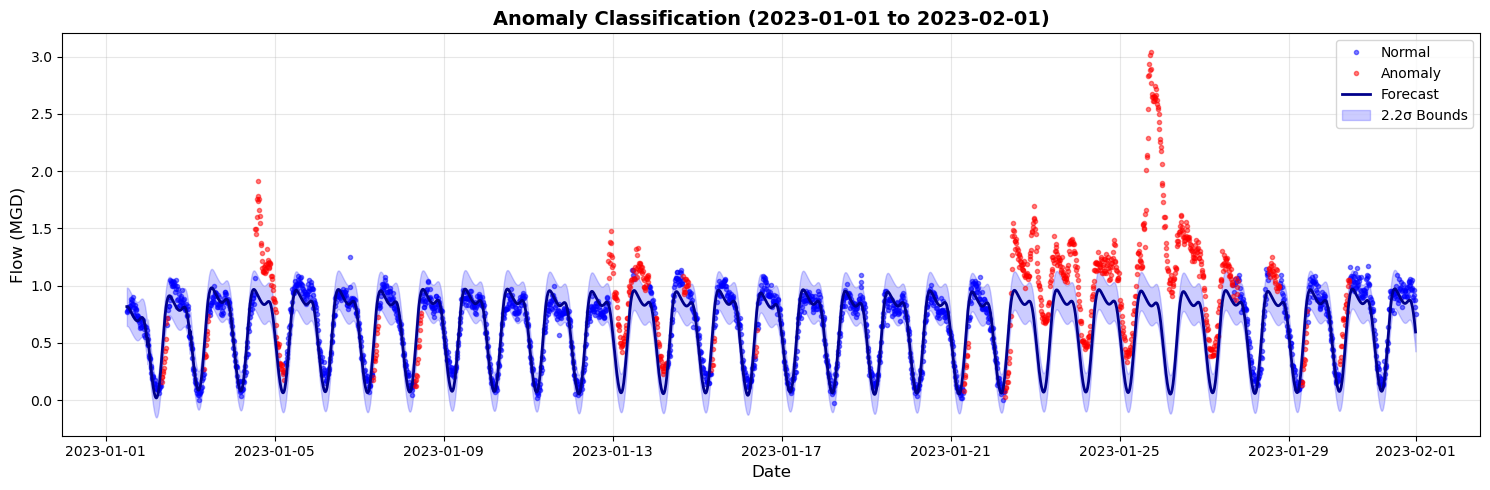

In [102]:
plot_final_classification(robust_results, start_date='2023-01-01', end_date='2023-02-01')


In [14]:
# src/rdii/process_rain.py
"""Module for cleaning sewer flow timeseries data."""

import sys
import pandas as pd
import numpy as np
import os
from pathlib import Path
import json
import time



df = pd.read_csv('data/processed/combined_flow_data.csv')
df.head()

df=df[['DateTime','Rain_in','Meter']]
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df.head()

# Daily
rain_daily = df.groupby('Meter').resample('D')['Rain_in'].sum().reset_index()

,Rain_in,Meter
DateTime,,
2023-01-01 12:00:00,0.0,CBO
2023-01-01 12:05:00,0.0,CBO
2023-01-01 12:10:00,0.0,CBO
2023-01-01 12:15:00,0.0,CBO
2023-01-01 12:20:00,0.0,CBO


In [39]:
data=pd.read_csv('data/processed/bwf_results.csv')
data.head()

,DateTime,Raw,GWI,Flow_MGD_GWI_Corrected,BWF_Anomaly,BWF,Meter
0,2023-01-01 12:00:00,1.496,0.729867,0.766133,False,0.808766,CBO
1,2023-01-01 12:15:00,1.505,0.729867,0.775133,False,0.808788,CBO
2,2023-01-01 12:30:00,1.516,0.729867,0.786133,False,0.806849,CBO
3,2023-01-01 12:45:00,1.547,0.729867,0.817133,False,0.803359,CBO
4,2023-01-01 13:00:00,1.516,0.729867,0.786133,False,0.798684,CBO


In [82]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data=data[['DateTime','Meter','Raw','GWI','BWF']]
data['RDII'] = data['Raw'] - data['GWI'] - data['BWF']
# RDII is alway greater than 0
data['RDII'] = data['RDII'].clip(lower=0)
data['BWF_GWI'] = data['BWF'] + data['GWI']


In [80]:
def plot_flow_components(df, meter_name, output_dir='results/plots', figsize=(14, 5), dpi=300):
    """
    Plot Raw, GWI, and BWF on a single axes for one meter.
    
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    df = df.copy()
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(df['DateTime'], df['Raw'], color='steelblue',   linewidth=0.8, label='Raw')
    ax.plot(df['DateTime'], df['GWI'], color='saddlebrown', linewidth=0.8, label='GWI')
    ax.plot(df['DateTime'], df['BWF_GWI'], color='darkgreen',   linewidth=0.8, label='BWF + GWI')

    ax.set_ylabel('Flow (MGD)')
    ax.set_xlabel('DateTime')
    ax.set_title(f'Flow Components — {meter_name}')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    output_file = output_path / f'{meter_name}_flow_components.png'
    #plt.savefig(output_file, dpi=dpi, bbox_inches='tight')
    #plt.close()
    #print(f"Saved: {output_file}")

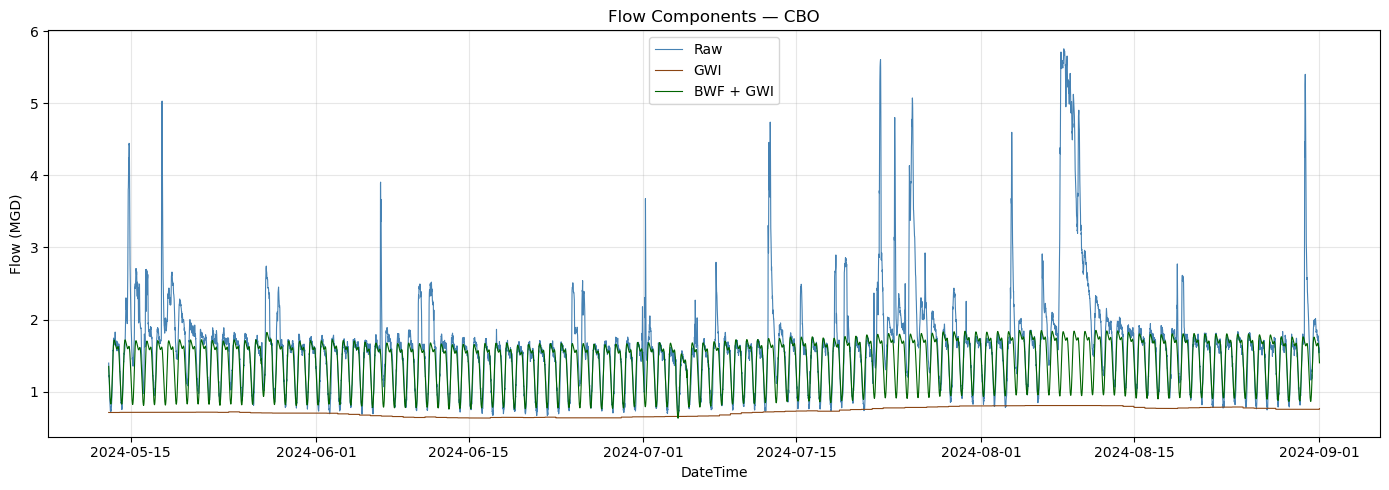

In [84]:
sub=data[data['Meter']=="CBO"]
sub=sub[sub['DateTime'] >= '2024-05-13']
sub=sub[sub['DateTime'] <= '2024-09-01']
plot_flow_components(sub, 'CBO')
